In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

the rand_state is set to a specific integer so the it ensures that the shuffle is the same  every time (controling the random seed)


In [12]:
df = pd.read_csv("Train_data.csv")
x = df.drop(columns=["class"])  
y = df["class"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Z-table approximation
it is done only using the mean and standarad deviation of the training set to avoid these problems  

Avoid Data Leakage: Calculating the mean and standard deviation on the whole dataset (train + test) can introduce "data leakage," where information from the test set influences the training process, potentially leading to overly optimistic results.

Consistency: By using the mean and standard deviation from the training data, you ensure that the transformation reflects only the information the model has learned from the training data. This way, the test set remains a truly unseen set for evaluation purposes.

In [ ]:
numerical_cols = x_train.select_dtypes(include=["float64", "int64"]).columns
train_mean= x_train[numerical_cols].mean()
train_std = x_train[numerical_cols].std()
train_z_scores = x_train.copy()
test_z_scores = x_test.copy()
train_z_scores[numerical_cols]=(x_train[numerical_cols]-train_mean)/train_std
test_z_scores[numerical_cols]=(x_test[numerical_cols]-train_mean)/train_std
#handling the case of inf values after approximation
#first replace the infwith nan
#then using the fillna method to replace nan with the mean
train_z_scores.replace([float('-inf'), float('inf')], float('nan'), inplace=True)
test_z_scores.replace([float('-inf'), float('inf')], float('nan'), inplace=True)
train_z_scores.fillna(train_z_scores[numerical_cols].mean(),inplace=True) # inplace will update the data frame
test_z_scores.fillna(test_z_scores[numerical_cols].mean(),inplace=True)
print(train_z_scores[numerical_cols])

19064    anomaly
11127     normal
6517     anomaly
2973      normal
13339    anomaly
          ...   
15322    anomaly
24483    anomaly
6778      normal
9500     anomaly
19865    anomaly
Name: class, Length: 7558, dtype: object
       duration  src_bytes  dst_bytes     land  wrong_fragment    urgent  \
741   -0.116529  -0.010490  -0.040987 -0.01065       -0.092033 -0.007531   
411   -0.116529  -0.010490  -0.040987 -0.01065       -0.092033 -0.007531   
17841 -0.116529  -0.010490  -0.040987 -0.01065       -0.092033 -0.007531   
20962 -0.116529  -0.010487  -0.040987 -0.01065       -0.092033 -0.007531   
17790 -0.116529  -0.010490  -0.040987 -0.01065       -0.092033 -0.007531   
...         ...        ...        ...      ...             ...       ...   
21575 -0.116529  -0.010474  -0.039978 -0.01065       -0.092033 -0.007531   
5390  -0.116174  -0.009934  -0.036354 -0.01065       -0.092033 -0.007531   
860   -0.116529  -0.010490  -0.040987 -0.01065       -0.092033 -0.007531   
15795 -0.116

threshhold tuning 
is used to be able to tell if the data is anomly or not using z score values 

True Positive (TP): Anomaly samples that were correctly predicted as anomalies.
False Negative (FN): Anomaly samples that were incorrectly predicted as normal (missed anomalies).
False Positive (FP): Normal samples that were incorrectly predicted as anomalies (false alarms).
True Negative (TN): Normal samples that were correctly      predicted as normal.

DataFrame.apply(func, axis=0, raw=False, result_type=None, args=(), **kwds)
train_z_scores[numerical_cols].apply(lambda x: abs(x) > threshold).any(axis=1) 
[(axis =1 )applys to rows // (axis=1 ) applys to columns ]
Lambda functions are simple, anonymous functions in Python.
They are useful for short operations that are used temporarily

    Threshold  Accuracy  Precision    Recall
0         0.5  0.465202   0.465202  1.000000
1         0.6  0.465202   0.465202  1.000000
2         0.7  0.465202   0.465202  1.000000
3         0.8  0.465202   0.465202  1.000000
4         0.9  0.471024   0.467884  0.998578
5         1.0  0.472876   0.468750  0.998294
6         1.1  0.479227   0.471744  0.997156
7         1.2  0.485446   0.474739  0.996871
8         1.3  0.701508   0.611190  0.984926
9         1.4  0.716592   0.623873  0.984073
10        1.5  0.734983   0.640222  0.982366
11        1.6  0.759196   0.663265  0.979807
12        1.7  0.539031   0.505112  0.449659
13        1.8  0.555703   0.528644  0.414676
14        1.9  0.562450   0.541850  0.384812
15        2.0  0.564832   0.546345  0.380546
16        2.1  0.566155   0.548826  0.378840
17        2.2  0.568669   0.553245  0.378271
18        2.3  0.577534   0.570004  0.374005
19        2.4  0.580577   0.575811  0.373720


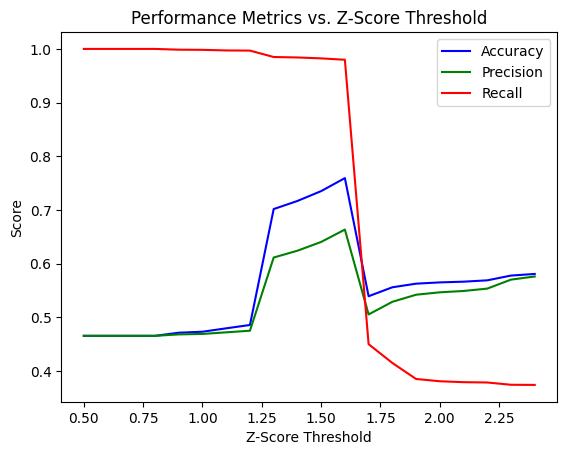

In [ ]:
# Define a range of z-score thresholds to try
thresholds = np.arange(0.5, 2.5, 0.1)  # from 1 to 4 in steps of 0.1

# Lists to store the metrics for each threshold
accuracy_scores = []
precision_scores = []
recall_scores = []
# Mapping the values inside the y_test to true and False to match the predicted values using the appply method
y_test_binary = y_test.map({'anomaly': True, 'normal': False})
for threshold in thresholds:
    # it predicts Normal or Anomaly based on the threshhold value (OR operation etween columns)
    train_z_scores['Predicted'] = train_z_scores[numerical_cols].apply(lambda x: abs(x) > threshold).any(axis=1)
    test_z_scores['Predicted'] = test_z_scores[numerical_cols].apply(lambda x: abs(x) > threshold).any(axis=1)
     # Ensure Predicted is boolean
    test_z_scores['Predicted'] = test_z_scores['Predicted'].astype(bool)
    # Calculate metrics using sklearn functions
    accuracy = accuracy_score(y_test_binary, test_z_scores['Predicted'])
    precision = precision_score(y_test_binary, test_z_scores['Predicted'], pos_label=True)  # Assuming 'Predicted' is the label
    recall = recall_score(y_test_binary, test_z_scores['Predicted'], pos_label=True)  # 

    # Store the metrics for each threshold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)

# Combine thresholds and scores into a DataFrame to view the results
results = pd.DataFrame({
    'Threshold': thresholds,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores
})

# Display the thresholds with corresponding metrics
print(results)


# Optionally, plot the metrics to visually inspect the best threshold
plt.plot(thresholds, accuracy_scores, label='Accuracy', color='blue')
plt.plot(thresholds, precision_scores, label='Precision', color='green')
plt.plot(thresholds, recall_scores, label='Recall', color='red')
plt.xlabel('Z-Score Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Performance Metrics vs. Z-Score Threshold')
plt.show()



so the best threshold is 1.5

Regarding the key metric selection
Precision: Best when minimizing false positives is important.
Recall: Best when minimizing false negatives is crucial.
